# Undercomplete autoencoders

In this notebook we explore the use of undercomplete autoencoders to compress data and synthesize new data.

A autoencoder, in its simplest form, is a neural network that is trained to match its output to its input.  The autoencoder is composed of two parts: an encoder $f$ and a decoder $g$.

$$\mathbf{x}_{out} = g(f(\mathbf{x}_{in}))$$

Here, both $f$ and $g$ will be implemented as multi-layer perceptrons, i.e. neural networks with multiple hidden layers and non-linear activation functions.

In an undercomplete autoencoder, the output of $f$ is smaller than the the input, so that the autoencoder learns to compress and decompress data.

In this notebook you will implement an undercomplete autoencoder and train it on the Frey dataset which contains about 2,000 faces of a single person's face with different poses and expressions.  Then you will explore how well the autoencoder can compress and decompress data, synthesize new data, and interpolate between faces.

In [0]:
import numpy as np
import matplotlib as mpl
mpl.rc('image', cmap='gray')
from matplotlib import pyplot as plt
from IPython.display import clear_output

## Data loading and pre-processing

Here we download and unpack the Frey dataset.  The dataset consists of grayscale images, 28 pixels high and 20 pixels wide.

In [2]:
from tensorflow.keras.utils import get_file
from scipy.io import loadmat

path = get_file('frey_rawface.mat','https://cs.nyu.edu/~roweis/data/frey_rawface.mat')
data = np.transpose(loadmat(path)['ff'])
images = np.reshape(data,(-1,28,20))
np.random.shuffle(images)

1105920/1100584 [==============================] - 1s 0us/step


(1965, 28, 20)


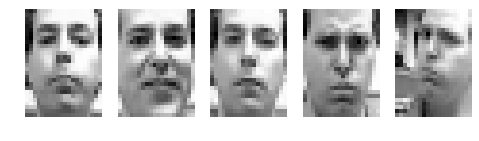

In [3]:
print(images.shape)
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(images[i])
  plt.axis('off')
plt.show()

We split the data into training and testing splits (the data was shuffled above) and then convert to floating point on [-1 1] range.

In [0]:
x_train = images[0:1800]
x_test = images[1800:]
x_train = (x_train.astype('float32')/255.)*2-1
x_test = (x_test.astype('float32')/255.)*2-1

## Model implementation and training

The code to build a linear autoencoder is given here.  Modify it to have multiple hidden layers with ReLU activation in the encoder and decoder.

### Encoder:
* Dense with 512 hidden units, ReLU activation
* Dense with 512 hidden units, ReLU activation
* Dense with 2 hidden units, tanh activation

### Decoder:
* Dense with 512 hidden units, ReLU activation
* Dense with 512 hidden units, ReLU activation
* Dense with 28*20 hidden units, linear activation


In [6]:
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

class Autoencoder:
  def __init__(self, input_dim, inner_activation): # 128 56 2 56 128
    self.inner_dim = 2
    self.input_dim = input_dim
    self.encoder_layers = []
    self.encoder_layers.append(Dense(512,activation='relu',name='encoder1'))
    self.encoder_layers.append(Dense(512,activation='relu',name='encoder2'))
    self.encoder_layers.append(Dense(self.inner_dim,activation=inner_activation,name='encoder3') ) #sparse would have regularization on here

    self.decoder_layers = []
    self.decoder_layers.append(Dense(512,activation='relu',name='decoder1'))
    self.decoder_layers.append(Dense(512,activation='relu',name='decoder2'))
    x = input_dim[0]
    for i in range(1,len(input_dim)):
      x = x * input_dim[i]
    self.decoder_layers.append(Dense(x,activation=None,name='decoder3'))
  
  def get_autoencoder(self):
    """ Builds the full autoencoder model with encoder and decoder. """
    inputs = Input(self.input_dim,name='autoencoder_input')
    x = Flatten()(inputs)
    for i in range(len(self.encoder_layers)):
      x = self.encoder_layers[i](x)
    for i in range(len(self.decoder_layers)):
      x = self.decoder_layers[i](x)
    outputs = Reshape(self.input_dim)(x)
    return Model(inputs=inputs,outputs=outputs)
  
  def get_encoder(self):
    """ Builds just the encoder model. """
    inputs = Input(self.input_dim,name='encoder_input')
    x = Flatten()(inputs)
    for i in range(len(self.encoder_layers)):
      x = self.encoder_layers[i](x)
    return Model(inputs=inputs,outputs=x)
  
  def get_decoder(self):
    """ Builds just the decoder model. """
    embedding = Input((self.inner_dim,),name='decoder_input')
    x = embedding
    for i in range(len(self.decoder_layers)):
      x = self.decoder_layers[i](x)
    outputs = Reshape(self.input_dim)(x)
    return Model(inputs=embedding,outputs=outputs)

autoencoder = Autoencoder((28,20), 'tanh')

ae_model = autoencoder.get_autoencoder()
encoder_model = autoencoder.get_encoder()
decoder_model = autoencoder.get_decoder()

ae_model.compile(SGD(0.01,momentum=0.9),loss='mean_absolute_error') # mse is better
print(ae_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
autoencoder_input (InputLaye (None, 28, 20)            0         
_________________________________________________________________
flatten (Flatten)            (None, 560)               0         
_________________________________________________________________
encoder1 (Dense)             (None, 512)               287232    
_________________________________________________________________
encoder2 (Dense)             (None, 512)               262656    
_________________________________________________________________
encoder3 (Dense)             (None, 2)                 1026      
_________________________________________________________________
decoder1 (Dense)             (None, 512)               1536      
_________________________________________________________________
decoder2 (Dense)             (None, 512)               262656    
__________

In [0]:
history = ae_model.fit(x_train,x_train,batch_size=32,epochs=1000,verbose=False,validation_split=0.1)

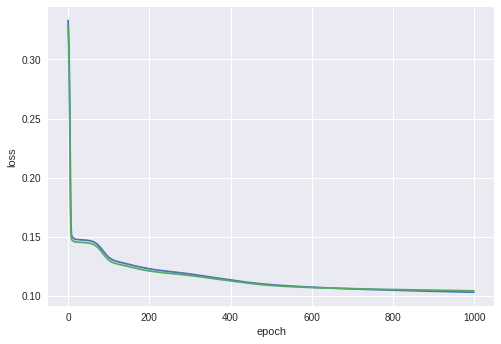

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## Exercises

*Before doing any of these exercises, make sure to modify the model as described above.*

* Test the ability of the autoencoder to compress and decompress the images.  Compare some input images to their reconstructions after running the autoencoder.  What effect does the autoencoder have on the images?
* VIsualize the output of the encoder (run on the training data) as a scatter plot.  Give some observations about the output.  Does it seem to be using all of the possible output space?
* Generate new faces by making a grid of embedding points on $[-1~1]\times[-1~1]$ (see code below).  Give some observations about the resulting images.
* Test interpolation between two images (see the example from the autoencoder notebook).  Give some observations about the output.
* Set up another autoencoder and train it on the spiral data from HW1.1. Visualize the embedding that it produces.  Does it produce an embedding where the separate spirals are linearly separable?  Does the autoencoder learn to map the spirals to tight, separated clusters?  (You might want to use linear activation rather than tanh for the encoder output in this part.)

###Reconstruction


The reconstructed images are a little less sharp than the original images. Small features such as the tongue and the eye region get obfuscated out. The autoencoder does capture the pose and general facial expression very well however. Overall, the image is recognizable as a face but is incredibly blurry.

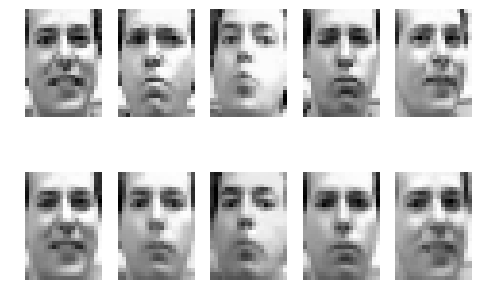

KeyboardInterrupt: ignored

In [0]:
import time
for j in range(0, 50, 5):
  for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(images[i+j])
    plt.axis('off')

  for i in range(5):
    pred_im = ae_model.predict(np.array([x_train[i+j]]))
    plt.subplot(2,5,i+6)
    plt.imshow(pred_im.reshape(28, 20))
    plt.axis('off')
  plt.show()

  time.sleep(3) #Waits 3 seconds then clears the plot
  plt.close()
  clear_output(wait=True)

###Encoding

The shape of the outputs from the encoding suggest there are two major grouping regions both forming crescents. Part of the space is not being used however. There is a large gap of values in the upper left area (x values < 0, y values > 0). Most of the rest of the space is being used except for a thin strip in between the two crescents. I noticed these areas and crescents moved around from training run to training run.

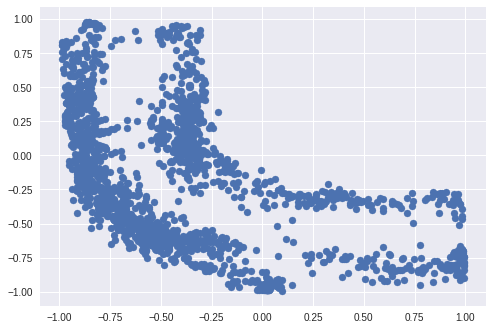

In [0]:
enc = encoder_model.predict(x_train)
plt.scatter(enc[:,0], enc[:,1])
plt.show()

###Generation

Based on the resulting images, it seems like the inner representation of the faces follows some defined manifolds. Rotation of the face is very apparent on the X-axis and it seems like expressions may be encoded on the Y-axis. Right in the middle of the space there seem to be very neutral faces which intuitively makes sense. One interesting feature of the space is that even when we decode an input from an area where that the network does not try to fill (see above) we still get a face that makes sense.

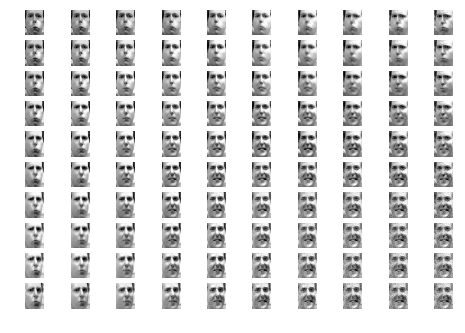

In [0]:
coords = np.linspace(-1,1,num=10)
x,y = np.meshgrid(coords,coords,indexing='xy')
embeddings = np.stack([x.flatten(),y.flatten()],axis=1)

ims = decoder_model.predict(embeddings)

for i in range(10):
  for j in range(10):
    plt.subplot(10,10,i*10+j+1)
    plt.imshow(ims[i*10+j])
    plt.axis('off')
plt.show()

###Interpolation

Interpolation creates very realistic looking faces. I chose two original images that are at different poses and the autoencoder was able to change the pose of the face in the interpolated images. The smile in the photos on the right is not very pronounced however. Interestingly, the middle images almost look like the person is grimacing which is a lot like trying to smile and frown at the same time.

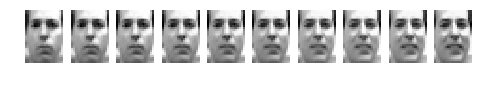

In [0]:
def interpolate_between(imgA_index,imgB_index):
  imgA = x_test[imgA_index]
  imgB = x_test[imgB_index]
  
  imgA_encoded = encoder_model.predict(x_test[imgA_index:(imgA_index+1)])
  imgB_encoded = encoder_model.predict(x_test[imgB_index:(imgB_index+1)])
  
  alphas = np.linspace(0,1,num=10)
  for n in range(10):
    alpha = alphas[n]
    img_encoded = (1-alpha)*imgA_encoded+alpha*imgB_encoded
    img = decoder_model.predict(img_encoded)
    plt.subplot(1,10,n+1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
  plt.show()

interpolate_between(0, 19)

###Spirals

In [0]:
import urllib.request
import tempfile
import shutil
from tensorflow.keras.utils import to_categorical

# get data from web and store to temporary file
with urllib.request.urlopen('http://cs.joensuu.fi/sipu/datasets/spiral.txt') as response:
    with tempfile.NamedTemporaryFile(delete=False) as tmp_file:
        shutil.copyfileobj(response, tmp_file)
data = np.loadtxt(tmp_file.name,delimiter='\t') # load data into numpy array
np.random.shuffle(data)  # shuffle the data so that the examples are randomly ordered
x = data[:,0:2] # extract the 2D coordinates of the points
y = data[:,2]-1 # extract the class labels and convert to zero-based indexing

y_onehot = to_categorical(y,3)
x_zerocentered = x - np.mean(x,axis=0,keepdims=True)

spiral_autoencoder = Autoencoder((2,), None)
spiral_ae = spiral_autoencoder.get_autoencoder()

spiral_ae.compile(SGD(0.01, momentum=0.9), loss='mae')
spiral_ae.summary()
history = spiral_ae.fit(x,x,batch_size=31,epochs=1000,verbose=False,validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
autoencoder_input (InputLaye (None, 2)                 0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 2)                 0         
_________________________________________________________________
encoder1 (Dense)             (None, 512)               1536      
_________________________________________________________________
encoder2 (Dense)             (None, 512)               262656    
_________________________________________________________________
encoder3 (Dense)             (None, 2)                 1026      
_________________________________________________________________
decoder1 (Dense)             (None, 512)               1536      
_________________________________________________________________
decoder2 (Dense)             (None, 512)               262656    
__________

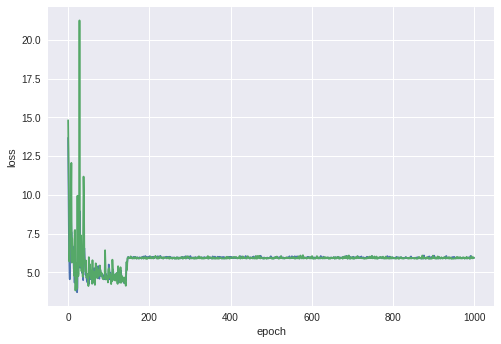

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

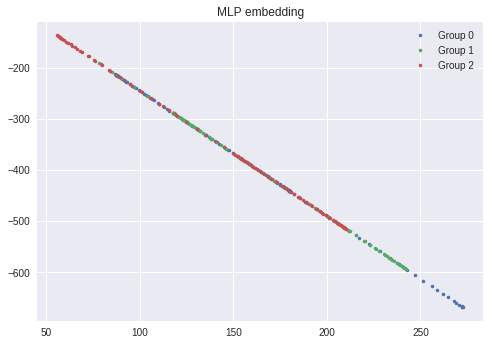

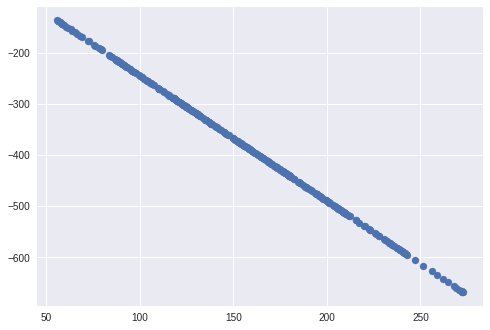

In [0]:
spiral_inner = spiral_autoencoder.get_encoder()

h = spiral_inner.predict(x)
for i in range(3):
  sel = y==i
  plt.plot(h[sel,0],h[sel,1],'.',label='Group %d'%i)
plt.title('MLP embedding')
plt.legend()
plt.show()